# Project Proposal - Best Predictors for Coronary Artery Disease
#### Group 006-44 - Erika Bush, Sophia Carrasco, Sarim Zulkifl

## Introduction

Coronary Artery Disease (CAD) is characterized by the narrowing of or blockage of a coronary artery as a result of plaque buildup. CAD is often described as a chronic disease with a sudden acute syndrome - a blood clot forms and results in a heart attack. As a heart attack-inducing condition, it is currently the leading cause of death in the world. As such, it is critical to identify risk factors and their relationships with this condition. Many have been identified, some of which are present in the data set that will be used in this project. The data frame was obtained from a paper that used those variables to calculate the probability for the diagnosis of CAD (Detrano et al., 1989).

#### In this project, we want to answer the question: What are the best variables for predicting a CAD diagnosis?

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dbplyr)
library(ggplot2)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#setting a fixed seed value (to be maintainied consistently throughout the entire project)
set.seed(50)


# Loading the dataset and ensuring that it is cleaned and wrangled
url <- "https://raw.githubusercontent.com/szulkifl/dsci-data-analysis-project-44/main/processed.hungarian.data.txt"
hungarian_data <- read_csv(url, col_names= c("age", "sex", "cp", "trestbps", 
                                             "chol", "fbs", "restecg", "thalac", "exang", "oldpeak", 
                                             "slope", "ca", "thal", "num" ),
                          show_col_types = FALSE) |>
                                             mutate(across(where(is.character), ~na_if(.x, "?"))) |> 
                                             mutate(trestbps = as.numeric(trestbps), 
                                                    chol = as.numeric(chol), 
                                                    restecg = as.numeric(restecg),
                                                    thalac = as.numeric(thalac),
                                                    num = as.character(num),
                                                    sex = as.character(sex)) |>
                                             mutate(num = fct_recode(num, "Negative" = "0", "Positive" = "1")) |>
                                             mutate(sex = recode(sex, "1" = "Male", "0" = "Female")) |>
                                             mutate(exang = recode(exang, "0" = "No", "1" = "Yes")) |>
                                             mutate (cp = recode( cp, "1" = "typical angina" , "2" = "atypical angina", 
                                                                "3" = "non-anginal pain", "4" = "asymptomatic" )) |>
                                             mutate (fbs = recode( fbs, "1" = "high fbs", "0" = "normal fbs")) |>
                  
                                             mutate(restecg = recode (restecg, "0" = "normal" , "1" = "abnormality", "2" = "hypertrophy"))

hungarian_data

age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<fct>
28,Male,atypical angina,130,132,normal fbs,hypertrophy,185,No,0,NA,NA,NA,Negative
29,Male,atypical angina,120,243,normal fbs,normal,160,No,0,NA,NA,NA,Negative
29,Male,atypical angina,140,NA,normal fbs,normal,170,No,0,NA,NA,NA,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,Male,asymptomatic,155,342,high fbs,normal,150,Yes,3,2,NA,NA,Positive
58,Female,atypical angina,180,393,normal fbs,normal,110,Yes,1,2,NA,7,Positive
65,Male,asymptomatic,130,275,normal fbs,abnormality,115,Yes,1,2,NA,NA,Positive


First, we have loaded and tidied the data. We have renamed all the columns, replaced any missing values (0, ?) with NA, changed the variables to be the appropriate type given the kind of variable it is (ie. categorical, numerical), and changed the values within those variables to match the type (eg. column sex becomes categorical, and the original values 0 and 1 become "Female" and "Male", respectively.

cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.3401361,7.823129,2.721088,0.3401361,0.3401361,0.3401361,0,64.62585,98.97959,90.47619


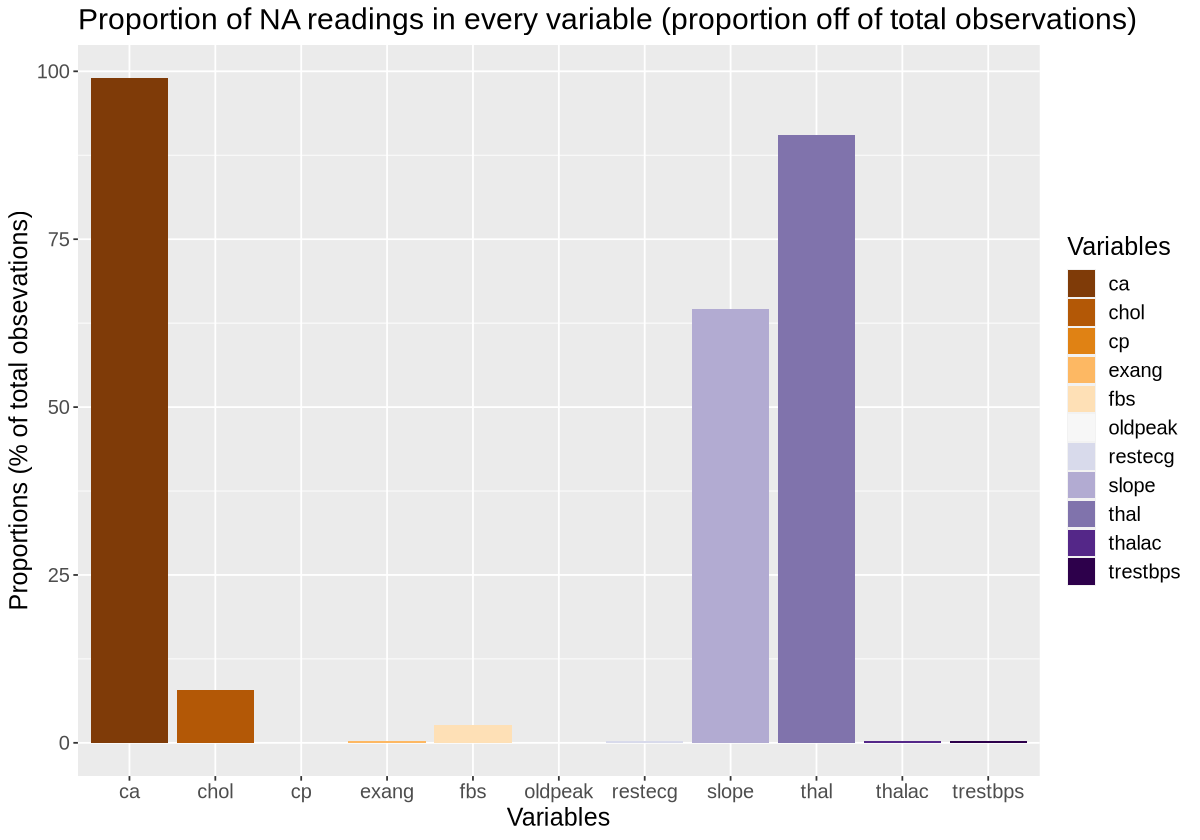

In [3]:
options(repr.plot.width = 10)
#number of observations
n_obs <- nrow(hungarian_data)
data_na_df <- hungarian_data |>
              select(cp:thal) |>
              map_df(~sum(is.na(.))) |>
              mutate(across(everything(), ~.x * (100/n_obs)))

data_na_df_vis <- pivot_longer(data_na_df,
                              cp:thal,
                              names_to = "Variables",
                              values_to = "Proportions") |>
                              ggplot(aes(x = Variables, y = Proportions, fill = Variables)) +
                              geom_bar(stat = "identity") +
                              scale_fill_brewer(palette = "PuOr") +
                              ggtitle("Proportion of NA readings in every variable (proportion off of total observations)") +
                              labs(x = "Variables",
                                  y = "Proportions (% of total obsevations)",
                                  fill = "Variables") +
                              theme(text = element_text(size = 15))
data_na_df
data_na_df_vis

The visualization above plots each variable against the percentage of missing observations. We can see that the columns for ca, slope and thal are quite tall, and thus a large percentage of their observations are missing.

## Further Cleaning
We ensure effective data analysis by removing select variables on the basis of two grounds:

### 1) Categorical Variables to be removed
Our purpose is to employ the K nearest neighbours classification algorithm to effectively predict the diagnosis of possible CAD. Hence, categorical values are of less precedence, allowing us to classify them as disposable variables. The categorical values that are to be removed are: cp, fbs, restecg, exang.

### 2) Variables with a large number of NA readings
As displayed by the table and the reading above, we can observe that the variables ca, slope, thal have 98%, 64%, and 90%  NA entries respectively. The large number of NA entries makes them hard/ unreliable to be used as classifying variables, giving us grounds to dispose of them.

**The variables we will discard are: cp, fbs, restecg, exang, ca, slope, thal** 

**The variables we will keep are: age (age), sex (sex), resting blood pressure(on admission to hospital) (trestbps), serum cholesterol in mg/di (chol), maximum heart rate achieved (thalac), ST depression induced by exercise relative to rest (oldpeak), and diagnosis(num)**

In [4]:
hungarian_data_new <- hungarian_data |>
                  select(age,sex,trestbps,chol,thalac,oldpeak,num)

# hungarian_data_new is the modified and cleaned dataset, 
# it is the cleanest version of our dataset which will now 
# be split into training and testing for the purpose of analysis.

hungarian_data_split <- hungarian_data_new |>
                        initial_split(prop = 0.75, strata = num)
hungarian_data_train <- training(hungarian_data_split)
hungarian_data_test <- testing(hungarian_data_split)

hungarian_data_new

age,sex,trestbps,chol,thalac,oldpeak,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,Male,130,132,185,0,Negative
29,Male,120,243,160,0,Negative
29,Male,140,NA,170,0,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,Male,155,342,150,3,Positive
58,Female,180,393,110,1,Positive
65,Male,130,275,115,1,Positive


## Elementary level exploratory analysis on current variables

#### 1. Average value across all predictor variables based on sex and diagnosis

In [5]:
hungarian_train_mean <- hungarian_data_train |>
                        group_by(sex, num) |>
                        summarize(age_mean = mean(age, na.rm = TRUE),
                                  trestbps_mean = mean(trestbps, na.rm = TRUE),
                                  chol_mean = mean(chol, na.rm = TRUE),
                                  thalac_mean = mean(thalac, na.rm = TRUE),
                                  oldpeak_mean = mean(oldpeak, na.rm = TRUE))
hungarian_train_mean


`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,num,age_mean,trestbps_mean,chol_mean,thalac_mean,oldpeak_mean
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,Negative,47.11321,127.2308,239.5625,146.9615,0.3075472
Female,Positive,48.71429,135.7143,308.0000,122.5714,1.0714286
Male,Negative,45.84091,130.3750,239.6125,146.9205,0.1704545
Male,Positive,49.36111,134.4167,264.2059,127.7778,1.3750000


#### 1. Maximum value across all predictor variables based on sex and diagnosis

In [6]:
hungarian_train_max <- hungarian_data_train |>
                        group_by(sex, num) |>
                        summarize(age_max = max(age, na.rm = TRUE),
                                  trestbps_max = max(trestbps, na.rm = TRUE),
                                  chol_max = max(chol, na.rm = TRUE),
                                  thalac_max = max(thalac, na.rm = TRUE),
                                  oldpeak_max = max(oldpeak, na.rm = TRUE))
hungarian_train_max


`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,num,age_max,trestbps_max,chol_max,thalac_max,oldpeak_max
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,Negative,62,180,394,190,2
Female,Positive,59,180,393,150,2
Male,Negative,62,190,365,185,3
Male,Positive,65,180,603,175,5


#### 3. Minimum value accross all predictor variables based on sex and diagnosis

In [7]:
hungarian_train_min <- hungarian_data_train |>
                        group_by(sex, num) |>
                        summarize(age_min = min(age, na.rm = TRUE),
                                  trestbps_min = min(trestbps, na.rm = TRUE),
                                  chol_min = min(chol, na.rm = TRUE),
                                  thalac_min = min(thalac, na.rm = TRUE),
                                  oldpeak_min = min(oldpeak, na.rm = TRUE))
hungarian_train_min


`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,num,age_min,trestbps_min,chol_min,thalac_min,oldpeak_min
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,Negative,30,100,160,90,0
Female,Positive,33,100,205,98,0
Male,Negative,28,98,85,98,0
Male,Positive,31,92,117,82,0


#### 4. Finding the number of Female and Male entries in the dataset

In [8]:
hungarian_train_female <- hungarian_data_train |>
                          filter(sex == "Female")|>
                          nrow()
hungarian_train_female  

# 60 females

hungarian_train_male <- hungarian_data_train |>
                          filter(sex == "Male")|>
                          nrow()
hungarian_train_male

# 160 males

[1] 60

[1] 160

### Distribution of age (in years) with respect to each diagnosis

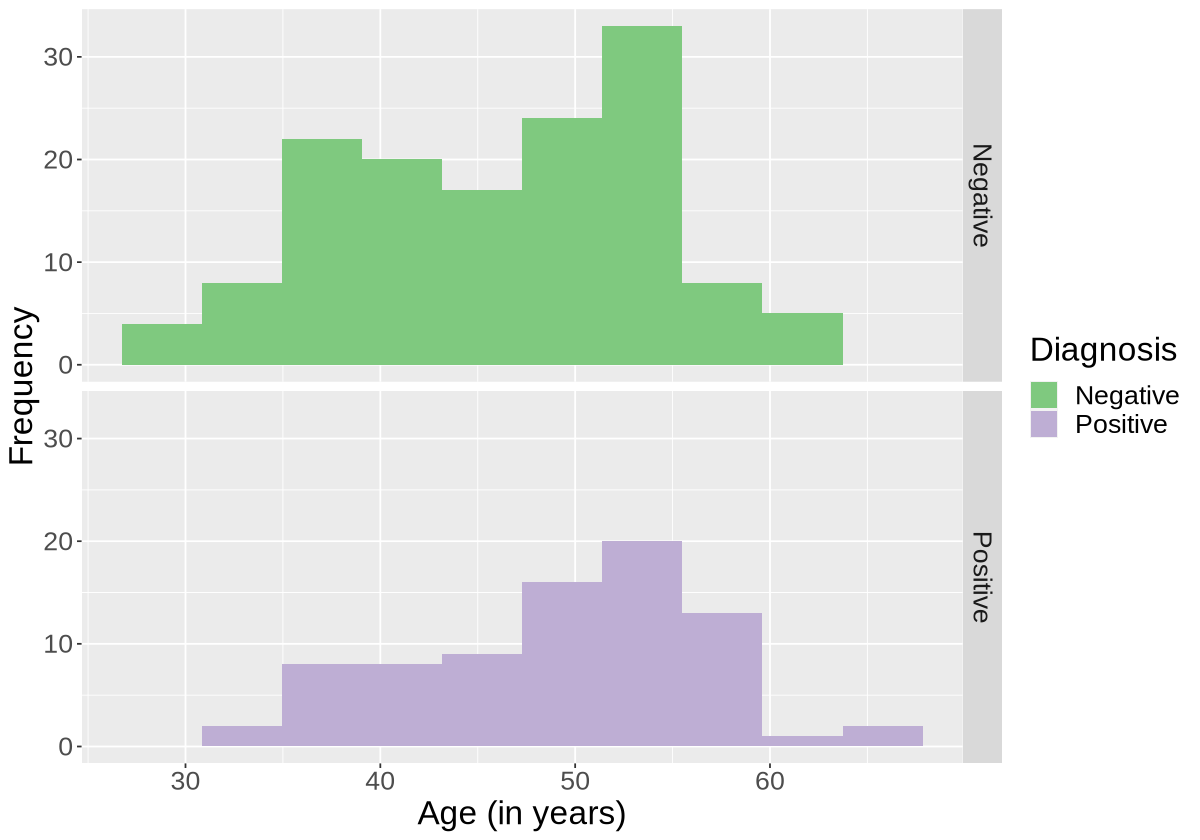

In [9]:
visualization_age <- hungarian_data_train |>
                     ggplot(aes(x = age, fill = num)) +
                     geom_histogram(bins = 10) +
                     labs(x = "Age (in years)", y = "Frequency", fill = "Diagnosis") +
                     facet_grid(rows = vars(num)) +
                     theme(text = element_text(size = 20)) +
                     scale_fill_brewer(palette = "Accent")
visualization_age

This visualization allows us to see how age plays a role in diagnosing CAD. There is a lot of overlap in ages of those both positively and negatively diagnosed, but those who were positively diagnosed are within the age range of ~30-70 years old, while those who were negatively diagnosed are within the range of ~25-65. From this, we can infer that CAD tends to be found in a slightly older age range of individuals, and thus conclude that age may be a useful variable to consider.

### Distribution of diagnoses, with respect to each sex

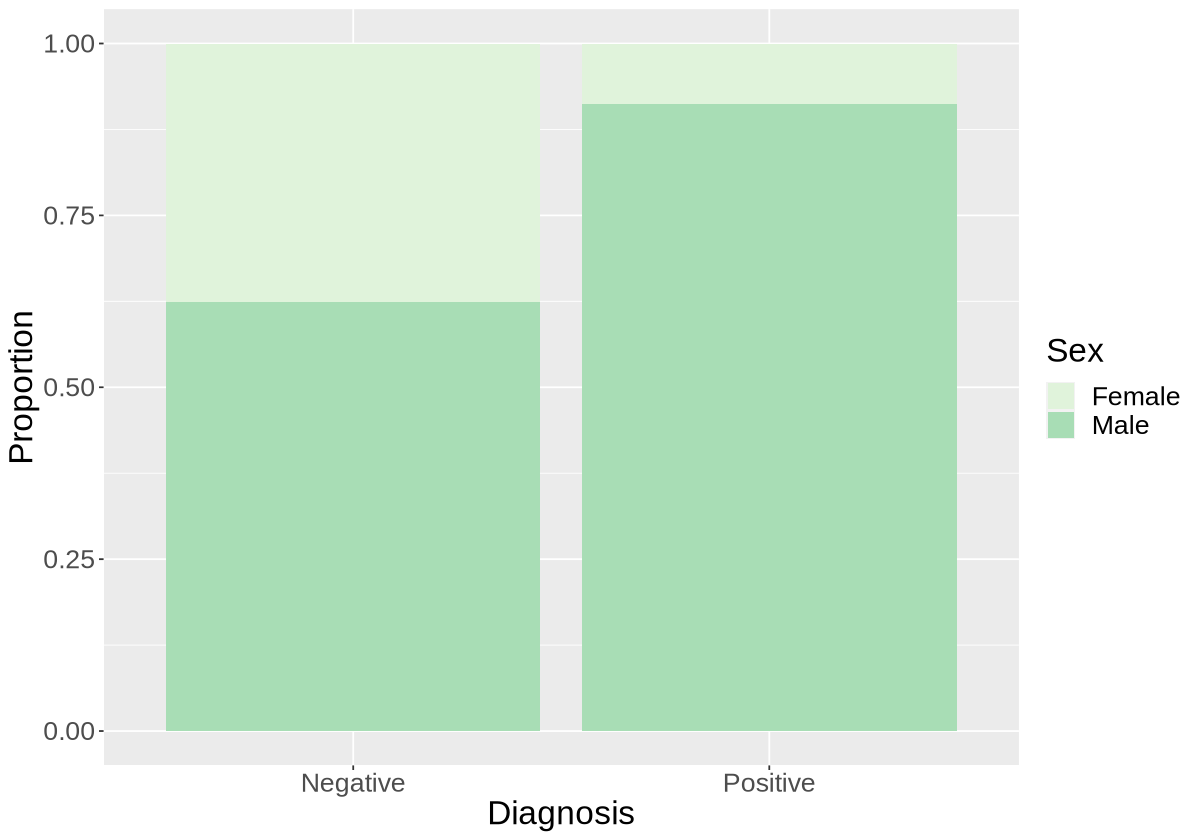

In [10]:
visualize_1 <- hungarian_data_train |>
               ggplot(aes(x = num, fill = sex)) +
               geom_bar(position = "fill") +
               labs(x = "Diagnosis", y = "Proportion", fill = "Sex") +
               scale_fill_brewer(palette = "GnBu") + 
               theme(text = element_text(size = 20))
visualize_1

This visualization allows us to see what proportion of males versus females are diagnosed with CAD. We know that there are more males than females in this dataset, so the fact that males are diagnosed more often than females for both diagnoses is not surprising. However, males are diagnosed positively more often than negatively, and vice versa for females, so we can infer that males are more at risk of CAD than females, and that sex may be a useful variable to consider.

### Distribution of Resting Blood Pressure on Admission (in mm) with respect to different diagnoses

Warning message:
“Removed 1 rows containing non-finite values (`stat_bin()`).”


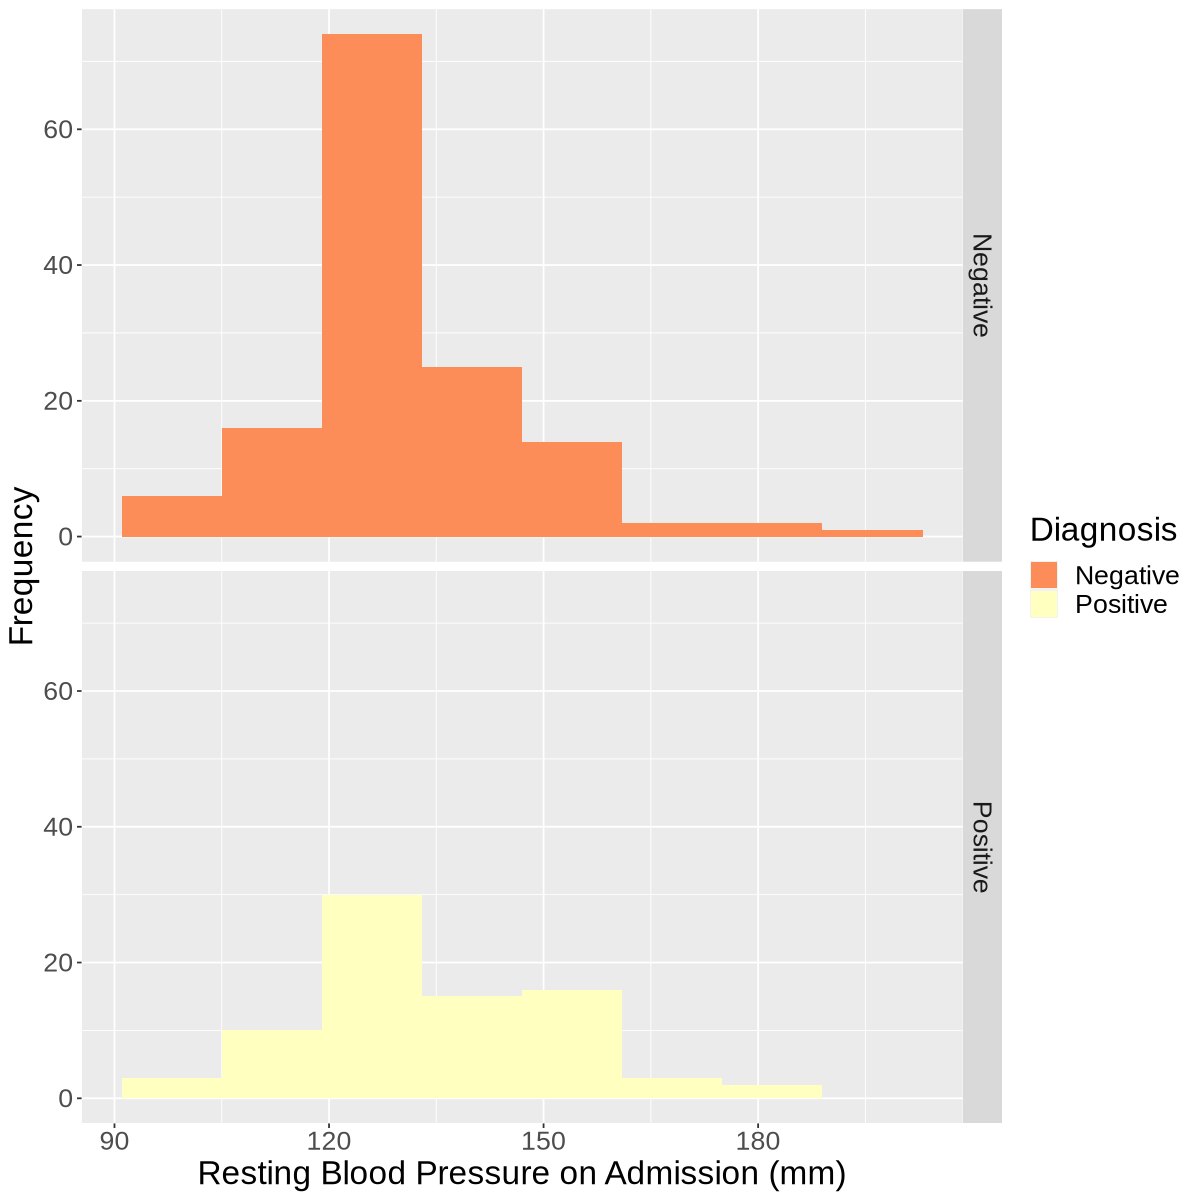

In [11]:
options(repr.plot.width = 10, repr.plot.height = 10)
hist_visualiz_trestbps <- hungarian_data_train |>
                 arrange(desc(age))  |>
                 ggplot(aes(x = trestbps, fill = num)) +
                 geom_histogram(bins = 8) +
                 facet_grid(rows = vars(num)) +
                 labs(x = "Resting Blood Pressure on Admission (mm)", y = "Frequency", fill = "Diagnosis") +
                 scale_fill_brewer(palette = "RdYlGn") + 
                 theme(text = element_text(size = 20))
                 
hist_visualiz_trestbps

This visualization allows us to see the distribution of resting blood pressure values between positive and negative diagnoses. The range of values is greater for negative diagnoses than positive diagnoses, so higher blood pressure might rule out a CAD diagnosis, and because of this potential, it may be a useful variable to consider.

### Distribution of Serum Cholesterol levels (in mg/dl) with respect to different diagnoses

Warning message:
“Removed 17 rows containing non-finite values (`stat_bin()`).”


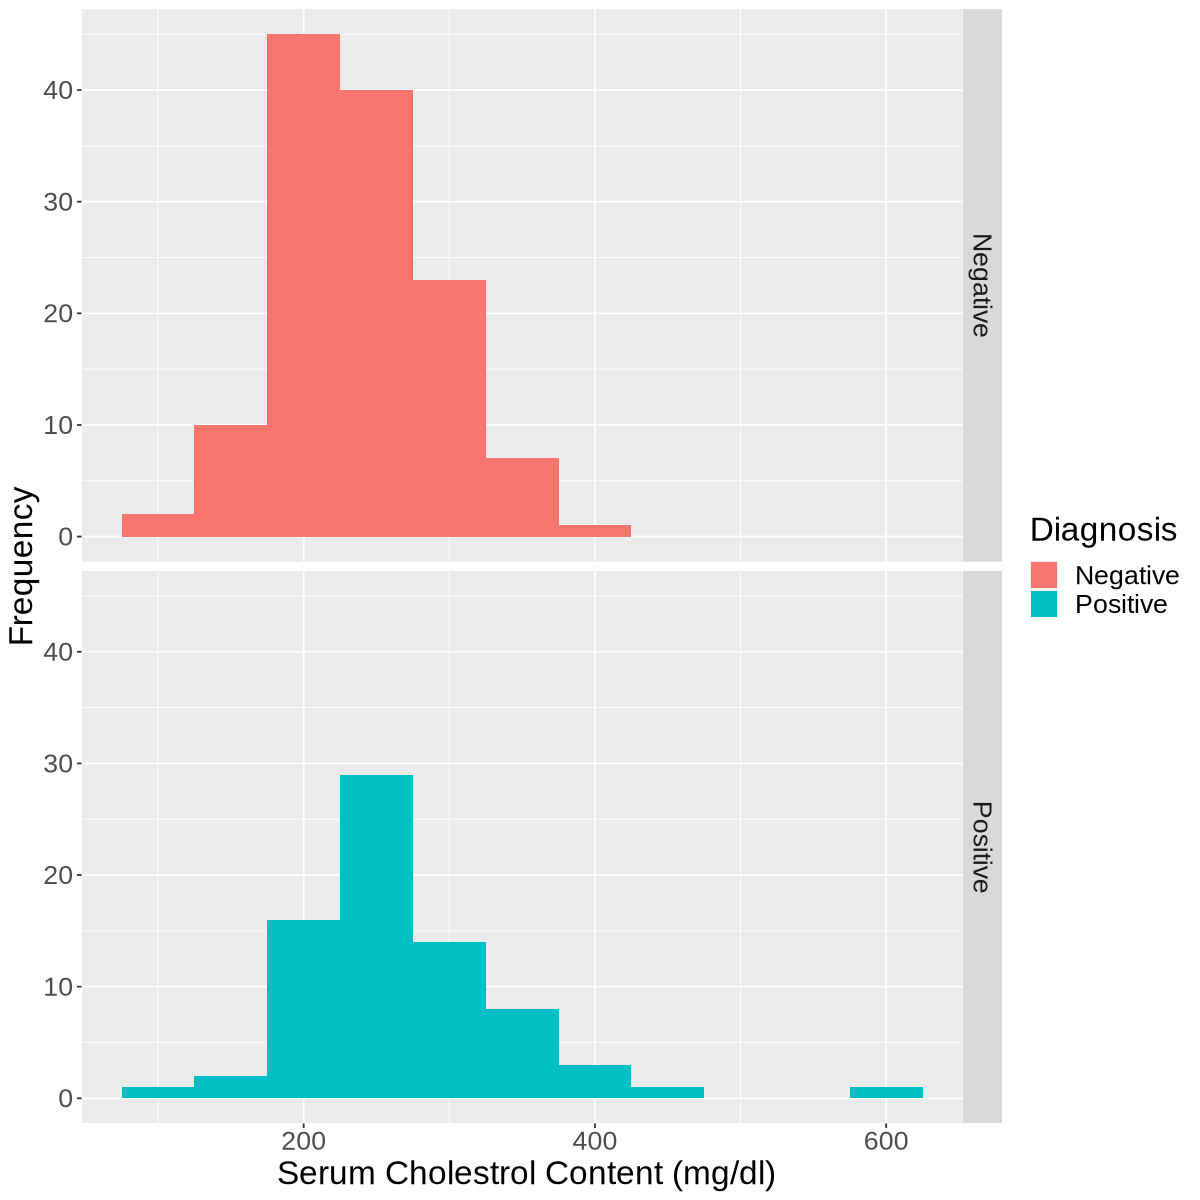

In [12]:
options(repr.plot.width = 10, repr.plot.height = 10)
hist_visualiz_chol <- hungarian_data_train |>
                 arrange(desc(age))  |>
                 ggplot(aes(x = chol, fill = num)) +
                 geom_histogram(binwidth = 50) +
                 facet_grid(rows = vars(num)) +
                 labs(x = " Serum Cholestrol Content (mg/dl)", y = "Frequency", fill = "Diagnosis") + 
                 theme(text = element_text(size = 20))
                 
hist_visualiz_chol

This visualization allows us to see the distribution of serum cholesterol content between positive and negative diagnoses. Serum content tends to be lower in negative diagnoses than positive diagnoses, and the range is also smaller than in positve diagnoses, so we can infer that cholesterol may be a useful variable to consider.

### Distribution of Maximum heart rate achieved (in bmp) during monitoring period, with respect to different diagnoses

Warning message:
“Removed 1 rows containing non-finite values (`stat_bin()`).”


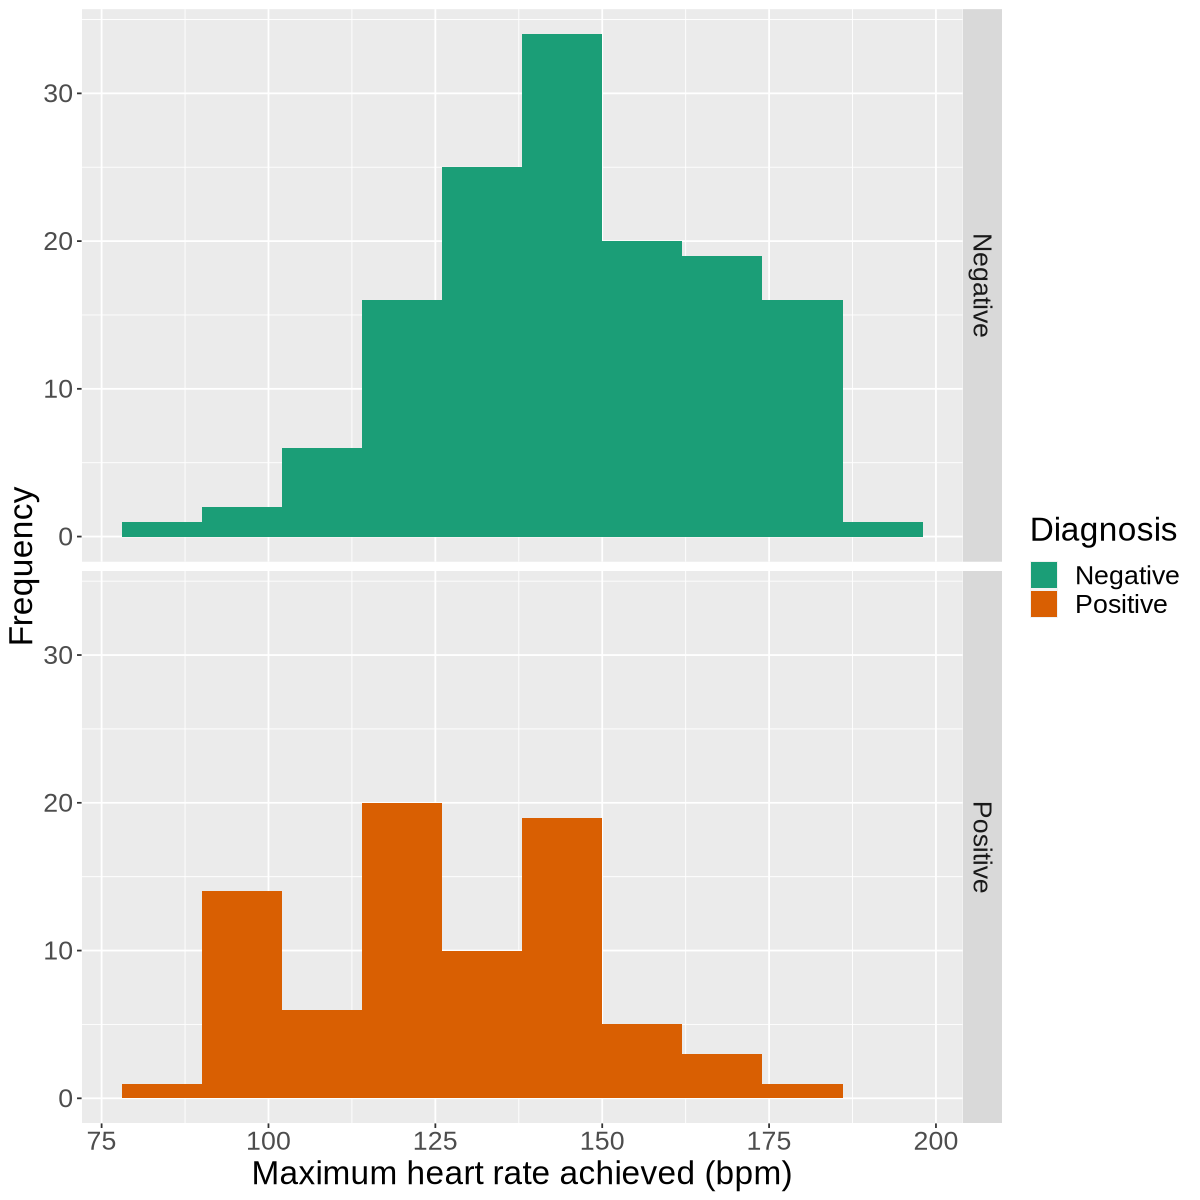

In [13]:

hist_visualize_thalac <- hungarian_data_train |>
                         ggplot(aes(x = thalac, fill = num)) +
                         geom_histogram(bins = 10) +
                         scale_fill_brewer(palette = "Dark2") +
                         labs(x = "Maximum heart rate achieved (bpm)", fill = "Diagnosis", y = "Frequency") +
                         facet_grid(rows = vars(num)) +
                         theme(text = element_text(size = 20))

hist_visualize_thalac

This visualization allows us to see the distribution of maximum heart rate values achieved, between positive and negative diagnoses. The range of values in negative diagnoses are concentrated higher than in positive diagnoses, so a low BPM may be a factor in diagnosing CAD, and thus we can conclude this may be a useful variable to consider. 

### Distribution of oldpeak values for different diagnoses

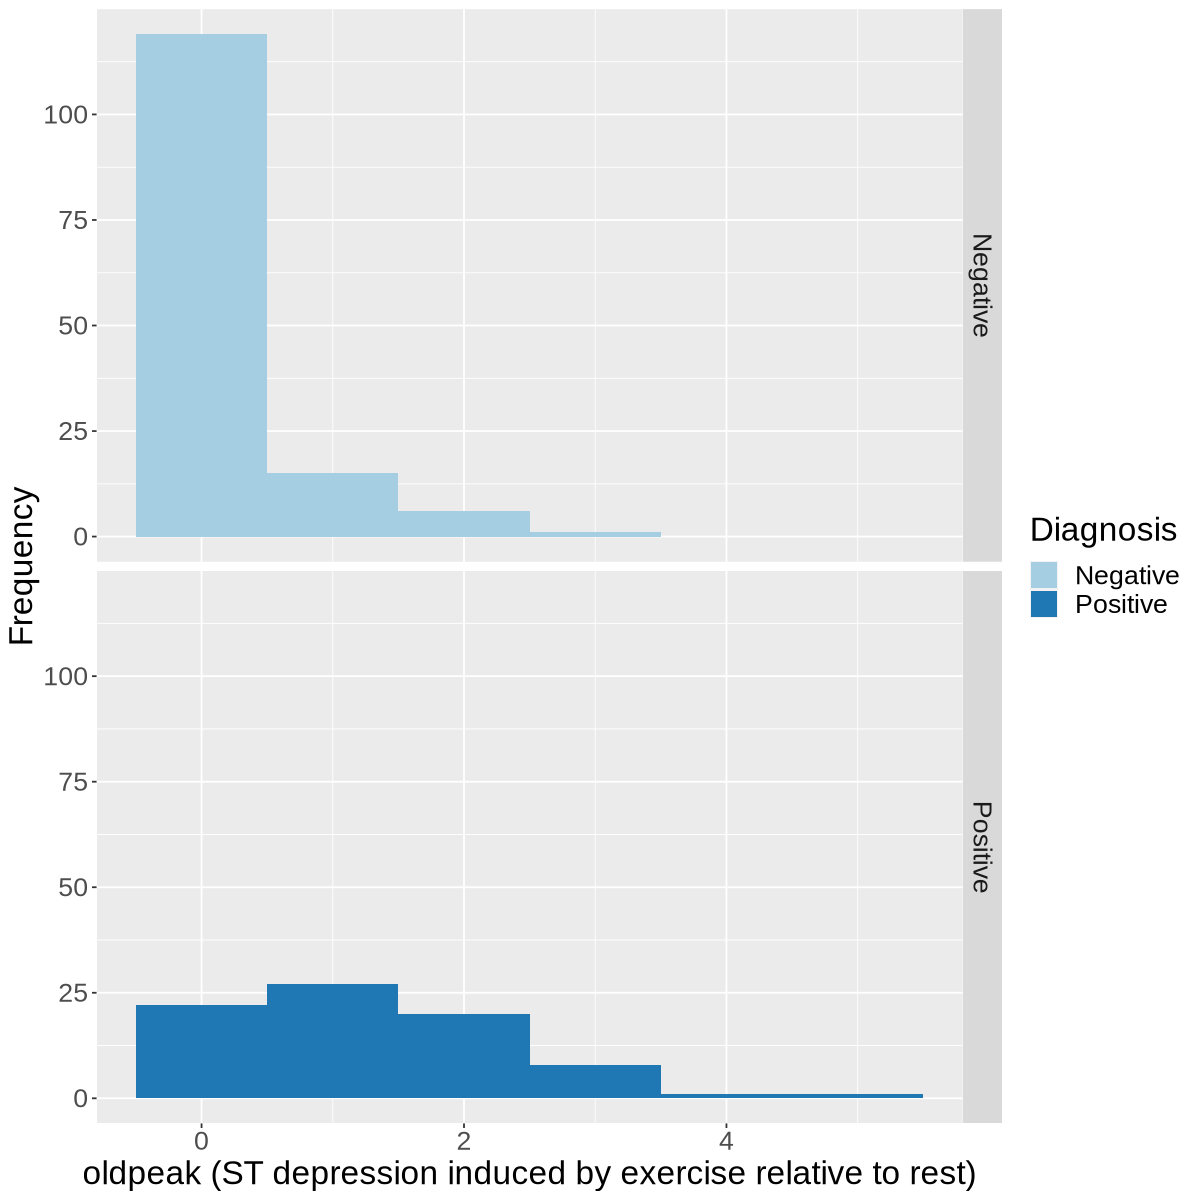

In [14]:
options(repr.plot.width = 10)
oldpeak_vis <- hungarian_data_train |>
               ggplot(aes(x = oldpeak, fill = num)) +
               geom_histogram(bins = 6) +
               facet_grid(rows = vars(num)) +
               labs(x = "oldpeak (ST depression induced by exercise relative to rest)",
                   y = "Frequency",
                   fill = "Diagnosis") +
               scale_fill_brewer(palette = "Paired") +
               theme(text = element_text(size = 20))
oldpeak_vis

The variable oldpeak measures how many times the ECG value measured in a patient drops below the J-joint threshold when exercising, relative to when resting. From this visualization, we can see the distribution of ST depression amounts between negative and positive diagnoses. The positive diagnosis has a larger range of measurements than the negative diagnosis, meaning patients diagnosed with CAD tend to experience more ST depression than patients negatively diagnosed. We can infer from this greater range of values in positive diagnoses that this variable would be useful to consider.

## Methods

We will use the age, sex, resting blood pressure (trestbps),  serum choleterol in mg/dl (chol), maximum heart rate (thalac) and oldpeak predictor variables. We removed the other 7 variables on grounds of insufficient entries or inappropriate variable type. We will build two knn classification models - one for females and one for males, due to relevant physiological differences - to predict a CAD diagnosis. 

We will be using the Hungarian data, as it had the most entries, and would therefore be the best choice for a classification model. We have split it and will train the classification model using part of it. After testing the effectiveness, we will visualize and plot the accuracy based on different k neighbour values. We will produce a line graph, plotting k values against an accuracy value (TBD), and find the best k value.


## Expected outcomes and significance

Our project aims to create two classifiers as well as determine the two k neighbour values that are best for each. We expect to find similar k neighbour values for males and females when predicting CAD. 
If the k neighbour values are very different between males and females, however, this finding could be useful when developing future medical  predictive algorithms. Within the medical field, knowledge is mostly based on observations and data from White males. Thus, diagnoses, including for CAD, may be less reliable for females. By creating two seaprate classifiers, we can tackle the potential disparities that arise between the different sexes, and potentially produce findings that lead to more inclusive and accurate diagnoses. Moreover,  creating this simple classifier could be useful for risk assessment in communities whrentesting is not as feasible to run, or accessible for patients. 
If the results obtained are significantly accurate, we could potentially apply the same classification procedure for other diseases. Another future question that may be explored is the role of race. How would our findings differ if we were to apply the same procedure to a dataset taken from a place with a different race of patients?
